In [17]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
import torch.nn as nn        #for all Neural Network stuff
import torch.optim as optim  #for all optimizer stuff

In [18]:
#method argument not needed??
data_size = 2000 #number of points in linspace
batch_time = 20 #number of points in the interval after a random starting point
batch_size = 500 #number of intervals
niters = 2000 #number of iterations
test_freq = 2
viz = True
gpu = 1
adjoint = True

In [19]:
from torchdiffeq import odeint_adjoint as odeint

In [20]:
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [21]:
#create linspace like usual
t = torch.linspace(0.0, 25.0, data_size)
g = 9.8
L1 = 1 
L2 = 1
m1 = 10
m2 = 10

In [22]:
def random():
    rand = 0
    while abs(rand) < 1 or abs(rand) > 3:
        rand = np.random.normal(0, 1, 1)[0]
    return rand

In [23]:
def getSlopesTorch(x,function):
    dim =  x.shape[0]**4
    slopeList = torch.zeros((dim,4))
    i = 0
    for f in x:
        for g in x:
            for h in x:
                for m in x:
                    #print(slope([],[f,g,h,m]))
                    slopeList[i] = function.forward([],torch.tensor([[f,g,h,m]]))
                    i += 1
    return slopeList

In [24]:
#lambda is a nn.Module like Linear, Conv2D etc,,
class Lambda(nn.Module):
    def forward(self,t,u):
        y = u[0]
        c, s = np.cos(y[0]-y[2]), np.sin(y[0]-y[2])
    
        de = torch.zeros_like(y)
        de[0] = y[1] #x1' = x2
        de[1] = (m2*g*np.sin(y[2])*c - m2*s*(L1*y[1]**2*c + L2*y[3]**2) - (m1 + m2)*g*np.sin(y[0]))/L1/(m1 + m2*s**2)
        de[2] = y[3] #y1' = y2
        de[3] = ((m1+m2)*(L1*y[1]**2*s - g*np.sin(y[2]) + g*np.sin(y[0])*c) + m2*L2*y[3]**2*s*c)/L2/(m1 + m2*s**2)

        return de

In [25]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time, dtype=np.int64), batch_size, replace=False))
#s is a torch tensor from a numpy array. the array is a random choice array, a rand number from 0 to ds-bt is chosen bs times.
#s has batch_size elements and each was equally likely to be chosen
#why ds-bt? why not just data_size as a rance since we are chosing from the t linspace with ds many points?
#it does ds-bt so that when it chooses the next bt number of points we will never fall out of the index range if
#    ds=1000 and bt=10 then then if i start at 990, I will end up with 990-1000 and not over.
    batch_y0 = true_y[s] #(M, D) <- idk what this means
#b_y0 is made of the randomly selected data points (dep vals) from true_y solution
    batch_t = t[:batch_time] #(T)
#b_t is the values rank 0 to b_time from your linspace t; the linspace values being looked at
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)],dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


In [26]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [27]:
def visualize(solution):
    
    #Draw
    theta1 = solution.numpy()[:,0,0]
    theta2 = solution.numpy()[:,0,2]
    x1_cor = 0
    y1_cor = 1

    x1 = L1 * np.sin(theta1) + x1_cor
    y1 = -L1 * np.cos(theta1) + y1_cor
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)

    plt.plot(x1,y1,'b',x2,y2,'g')

    plt.xlim(-2,2)
    plt.ylim(-1,3)
    plt.savefig('png/{:03d}'.format(itr))
    plt.show()

In [28]:
class ODEFunc(nn.Module): #create an ODE block as our neural network. usually multiple layers/modules
    
    def __init__(self):
        super(ODEFunc, self).__init__()
#self.net is the neural network layers one after the other L -> T -> L        
        self.net = nn.Sequential(    
            nn.Linear(4,50),
            nn.Tanh(),
            nn.Linear(50,100),
            nn.Tanh(),
            nn.Linear(100,50),
            nn.Tanh(),
            nn.Linear(50,4),
        )
        
        for m in self.net.modules():
            if isinstance(m,nn.Linear): #checks in the module m in self.net is an instance of the nn.Linear class
                nn.init.normal_(m.weight, mean=0, std=0.2) #for the Linear modules make all the weights randn with std 0.1
                nn.init.constant_(m.bias, val=0) #for the Linear modules make all the bias vector values 0
    
    def forward(self, t, y):
        return self.net(y) #essentially Lambda.forward(args) without the true_A >>>which is TBD<<<

In [29]:
class RunningAverageMeter(object): #Computes and stores the average and current value
    def __init__(self, momentum=0.99): #new object of this class will have mom of 0.99 and a reset val and avg
        self.momentum = momentum
        self.reset()
    def reset(self):                   #reset function called to set val and avg to None and 0 respectively
        self.val = None
        self.avg = 0
    def update(self, val):             #update is called externally to update the avg based on val
        if self.val is None:
            self.avg = val
        else:
            self.avg = (self.avg * self.momentum) + (val * (1 - self.momentum)) #reminds me of output error at L

Iteration 0001 | Total Loss 10.512710
Iteration 0002 | Total Loss 18.816513


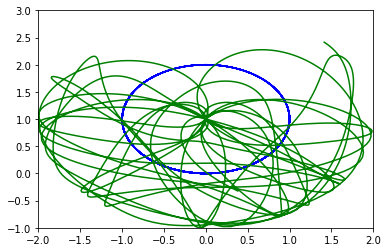

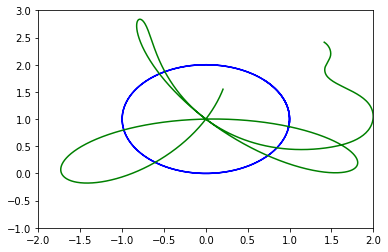

Iteration 0003 | Total Loss 8.404228
Iteration 0004 | Total Loss 10.416856


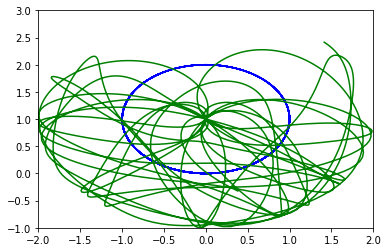

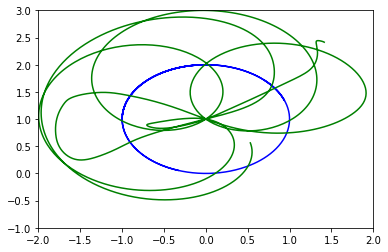

Iteration 0005 | Total Loss 10.417185
Iteration 0006 | Total Loss 6.960486


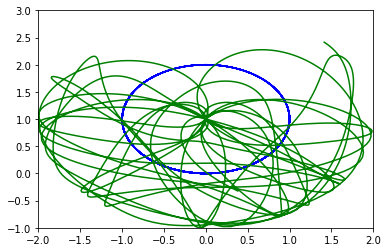

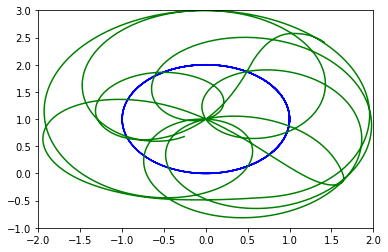

Iteration 0007 | Total Loss 4.322605
Iteration 0008 | Total Loss 4.046969


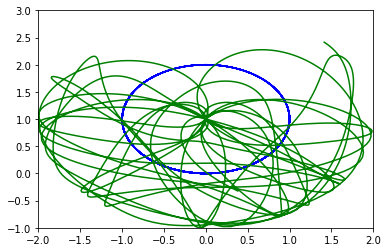

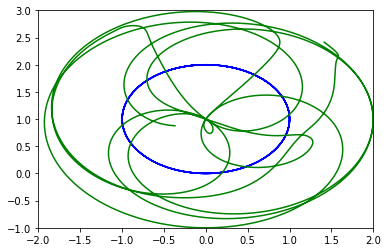

Iteration 0009 | Total Loss 4.402848
Iteration 0010 | Total Loss 4.056067


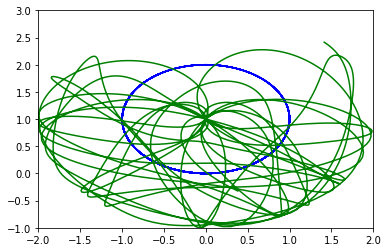

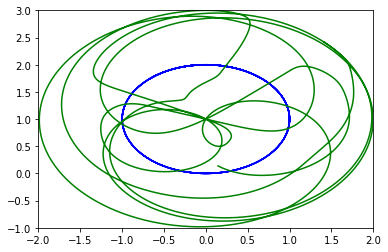

Iteration 0011 | Total Loss 4.167369
Iteration 0012 | Total Loss 3.552418


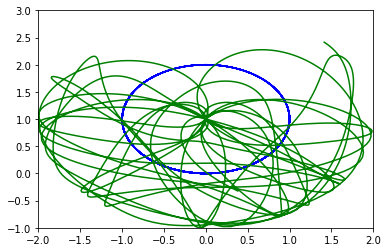

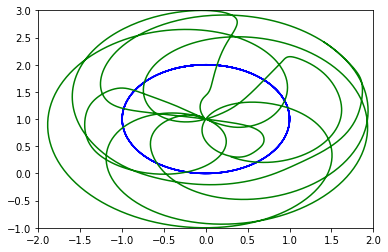

Iteration 0013 | Total Loss 3.543119
Iteration 0014 | Total Loss 3.209780


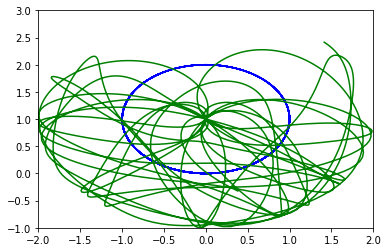

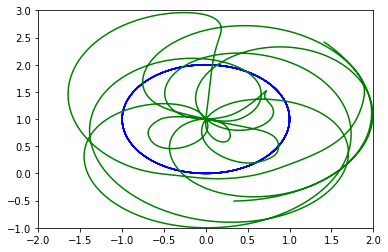

Iteration 0015 | Total Loss 3.258858
Iteration 0016 | Total Loss 3.062790


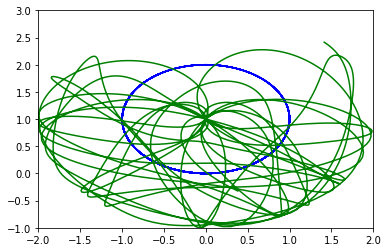

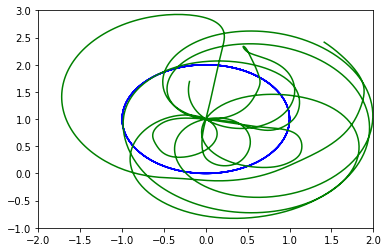

Iteration 0017 | Total Loss 3.153122
Iteration 0018 | Total Loss 2.973784


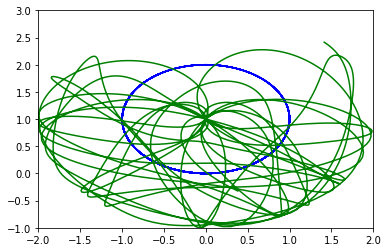

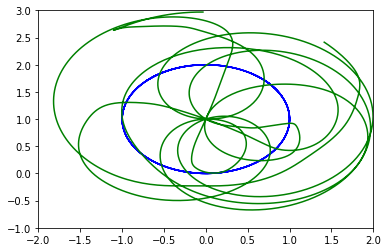

Iteration 0019 | Total Loss 3.070891
Iteration 0020 | Total Loss 2.928918


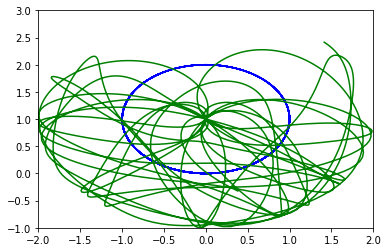

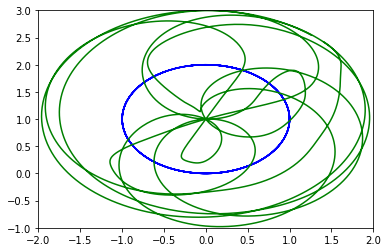

Iteration 0021 | Total Loss 3.217421
Iteration 0022 | Total Loss 3.314146


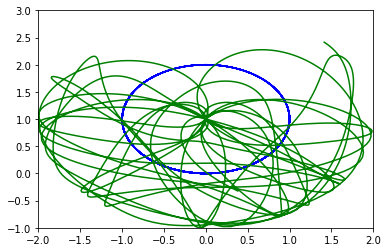

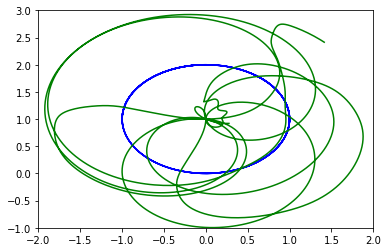

Iteration 0023 | Total Loss 3.363400
Iteration 0024 | Total Loss 2.983835


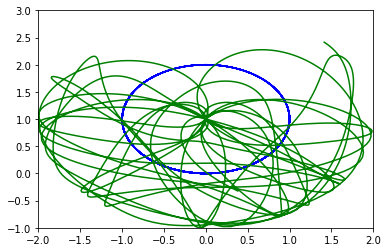

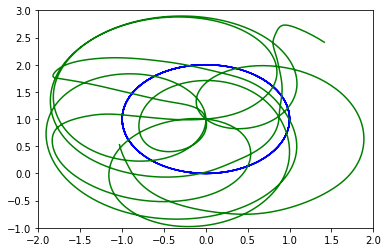

Iteration 0025 | Total Loss 2.696083
Iteration 0026 | Total Loss 2.552037


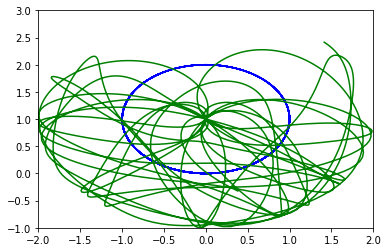

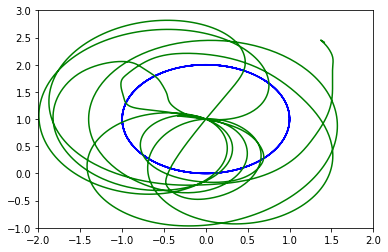

Iteration 0027 | Total Loss 2.551837
Iteration 0028 | Total Loss 2.566553


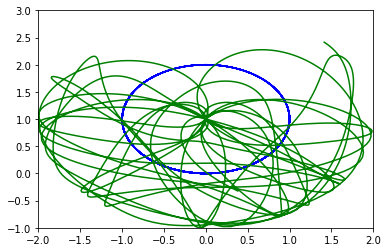

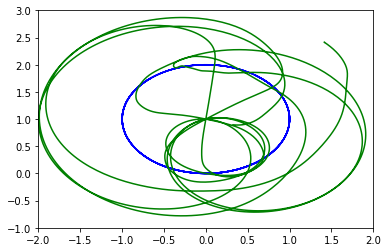

Iteration 0029 | Total Loss 2.739527
Iteration 0030 | Total Loss 2.694425


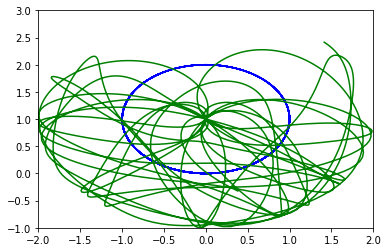

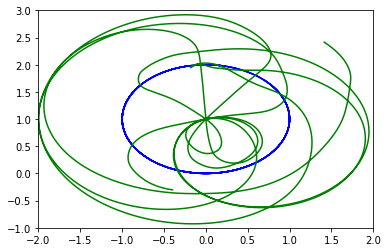

Iteration 0031 | Total Loss 2.877590
Iteration 0032 | Total Loss 2.620596


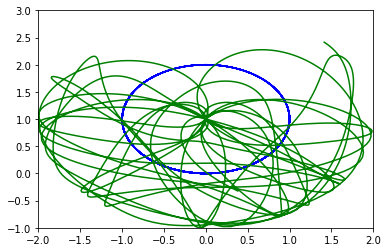

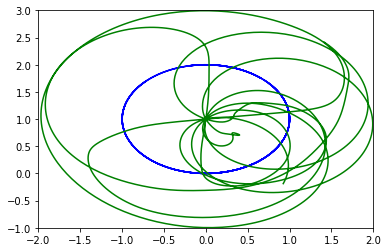

Iteration 0033 | Total Loss 2.673697
Iteration 0034 | Total Loss 2.552226


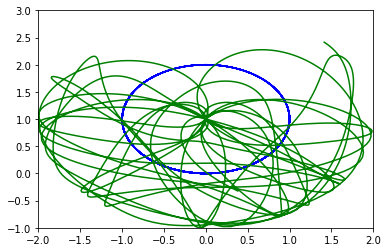

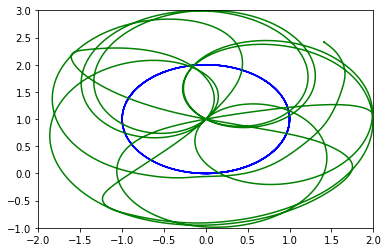

Iteration 0035 | Total Loss 2.638528
Iteration 0036 | Total Loss 2.608842


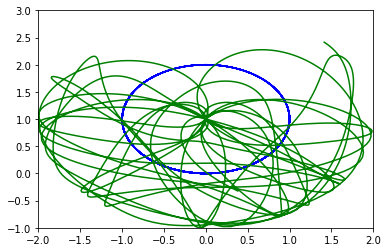

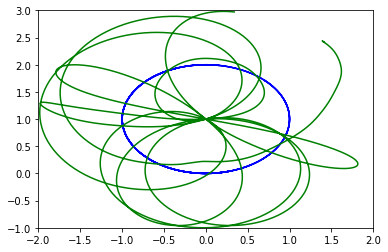

Iteration 0037 | Total Loss 2.594521
Iteration 0038 | Total Loss 2.494869


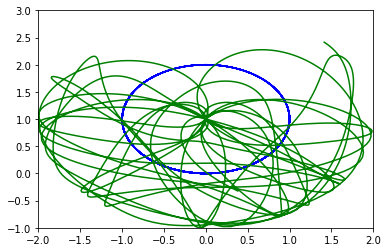

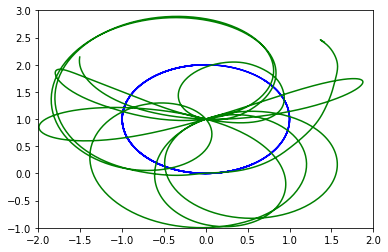

Iteration 0039 | Total Loss 2.525471
Iteration 0040 | Total Loss 2.398272


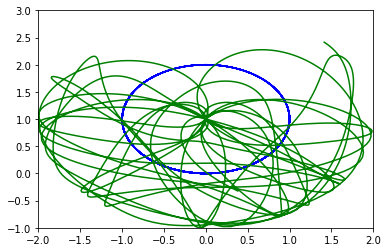

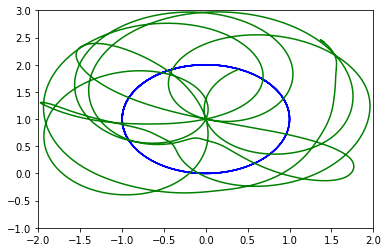

Iteration 0041 | Total Loss 2.478505
Iteration 0042 | Total Loss 2.284093


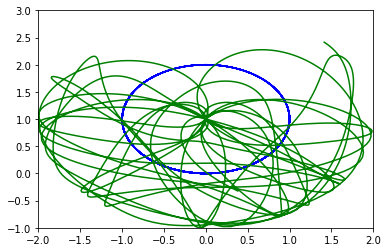

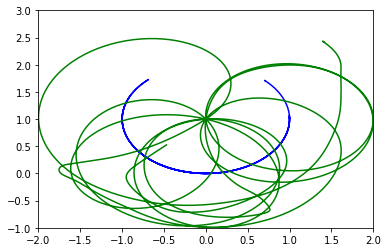

Iteration 0043 | Total Loss 2.356979
Iteration 0044 | Total Loss 2.195032


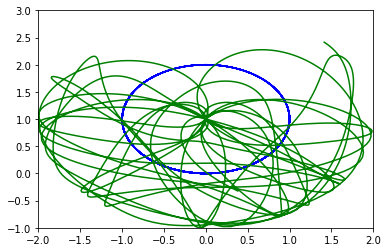

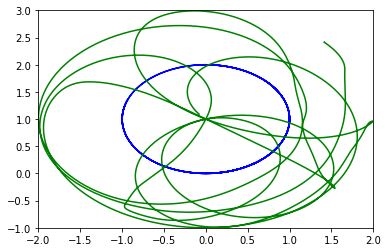

Iteration 0045 | Total Loss 2.287282
Iteration 0046 | Total Loss 2.148795


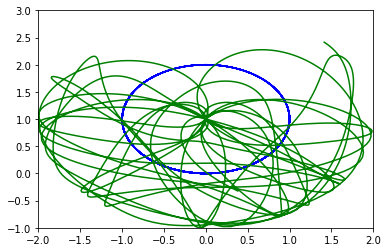

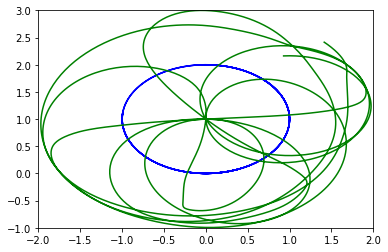

Iteration 0047 | Total Loss 2.241587
Iteration 0048 | Total Loss 2.090540


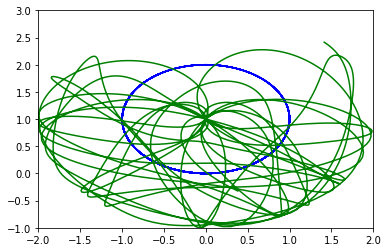

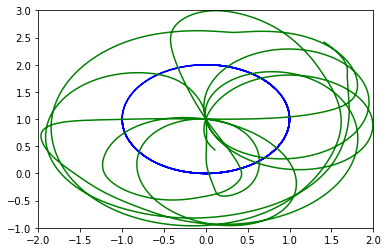

Iteration 0049 | Total Loss 2.170771
Iteration 0050 | Total Loss 2.022953


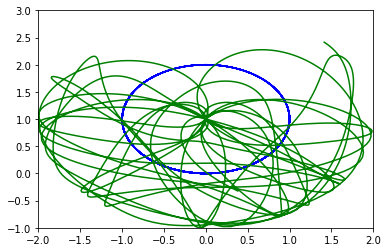

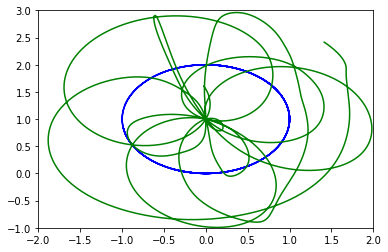

Iteration 0051 | Total Loss 2.112758
Iteration 0052 | Total Loss 1.968047


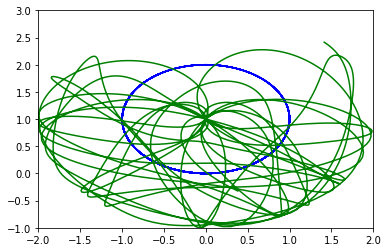

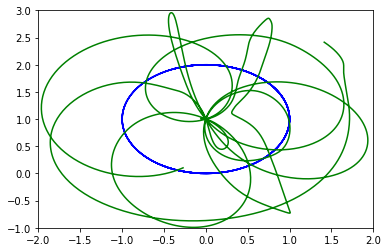

Iteration 0053 | Total Loss 2.073011
Iteration 0054 | Total Loss 1.919967


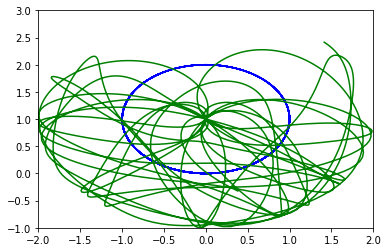

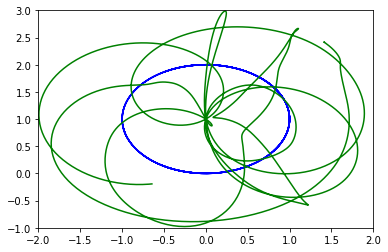

Iteration 0055 | Total Loss 2.032799
Iteration 0056 | Total Loss 1.877815


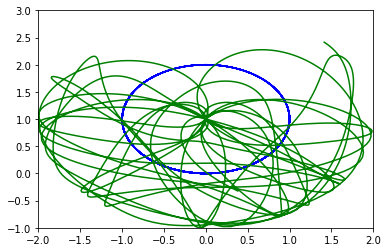

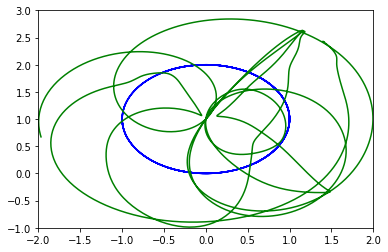

Iteration 0057 | Total Loss 1.996633
Iteration 0058 | Total Loss 1.845120


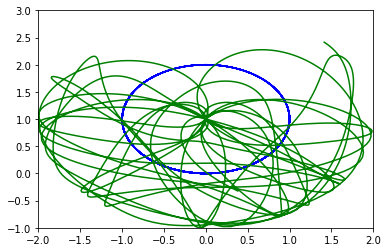

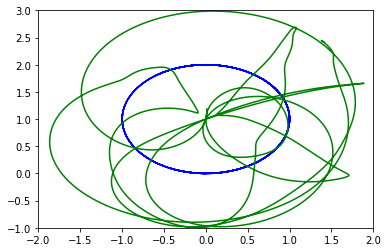

Iteration 0059 | Total Loss 1.964485
Iteration 0060 | Total Loss 1.812474


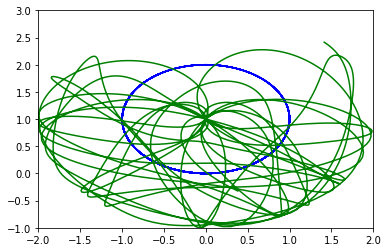

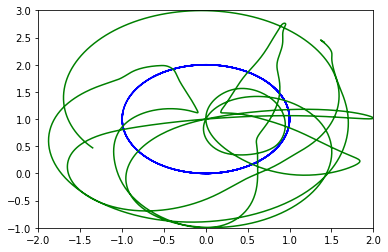

Iteration 0061 | Total Loss 1.927562
Iteration 0062 | Total Loss 1.775168


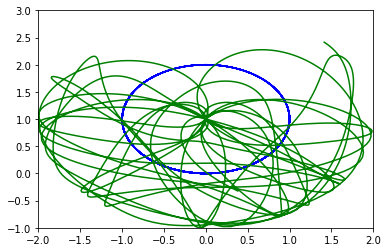

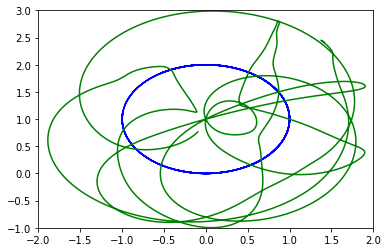

Iteration 0063 | Total Loss 1.891029
Iteration 0064 | Total Loss 1.736809


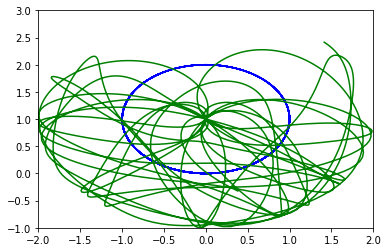

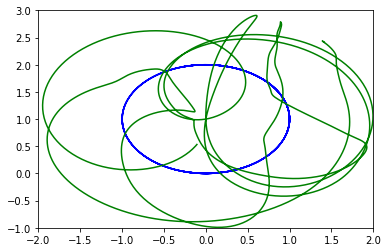

Iteration 0065 | Total Loss 1.854464
Iteration 0066 | Total Loss 1.700937


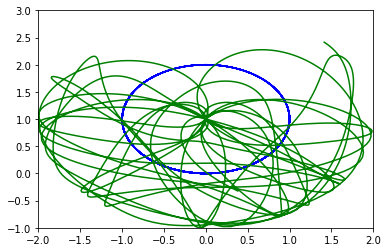

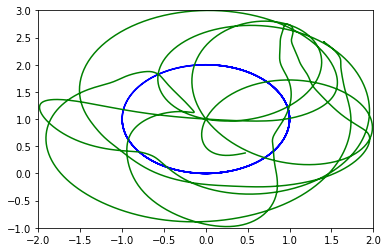

Iteration 0067 | Total Loss 1.820952
Iteration 0068 | Total Loss 1.678889


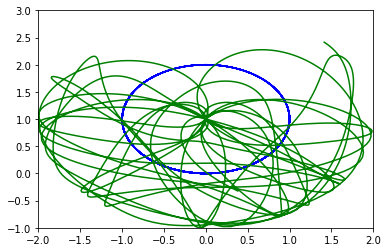

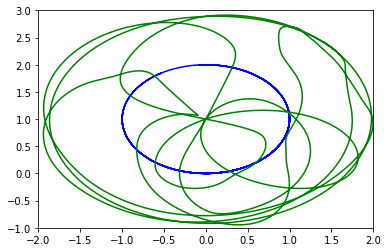

Iteration 0069 | Total Loss 1.808748
Iteration 0070 | Total Loss 1.690069


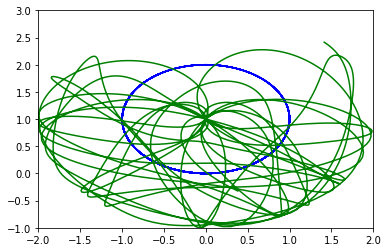

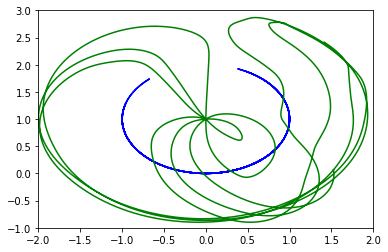

Iteration 0071 | Total Loss 1.841818
Iteration 0072 | Total Loss 1.770670


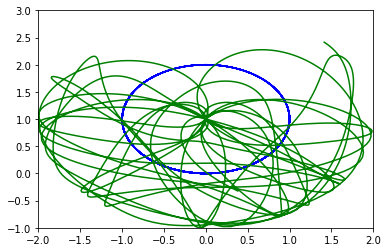

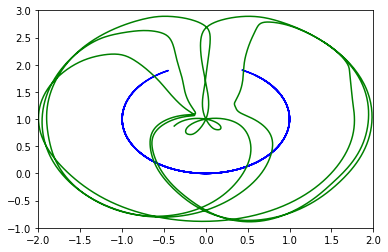

Iteration 0073 | Total Loss 1.922541
Iteration 0074 | Total Loss 1.872824


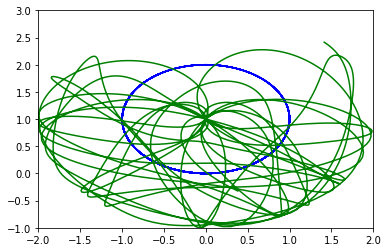

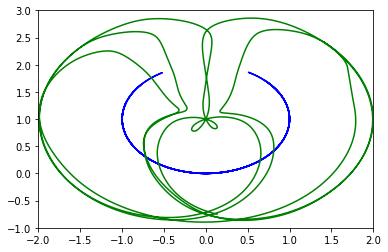

Iteration 0075 | Total Loss 1.905159
Iteration 0076 | Total Loss 1.792068


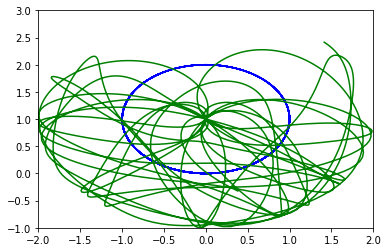

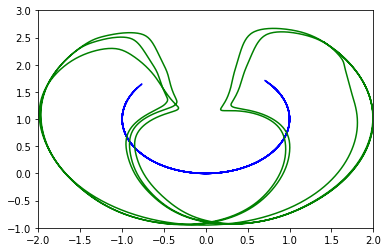

Iteration 0077 | Total Loss 1.782630
Iteration 0078 | Total Loss 1.642048


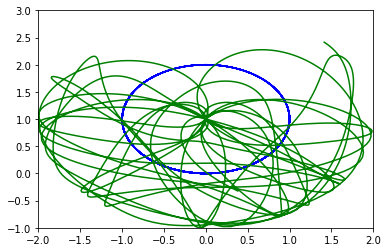

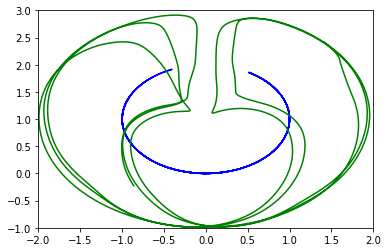

Iteration 0079 | Total Loss 1.653119
Iteration 0080 | Total Loss 1.523398


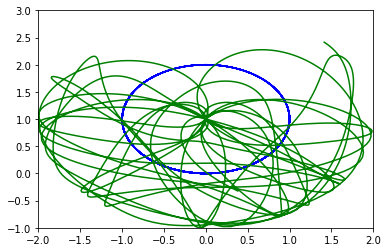

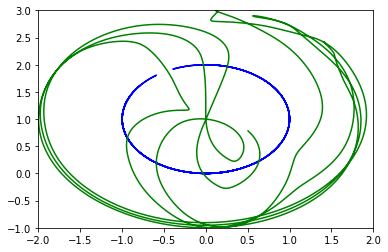

Iteration 0081 | Total Loss 1.584565
Iteration 0082 | Total Loss 1.462620


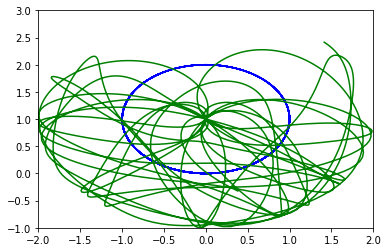

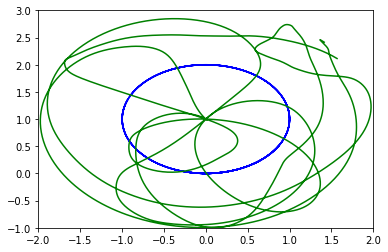

Iteration 0083 | Total Loss 1.548603
Iteration 0084 | Total Loss 1.447103


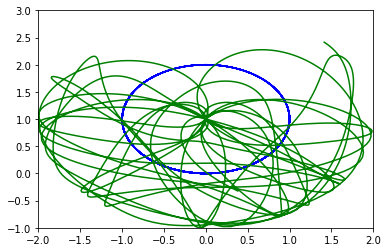

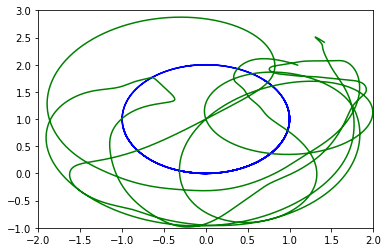

Iteration 0085 | Total Loss 1.531485
Iteration 0086 | Total Loss 1.449683


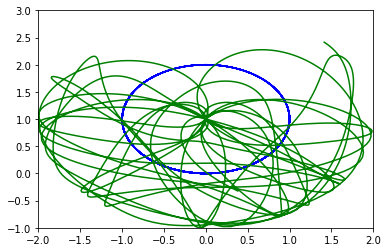

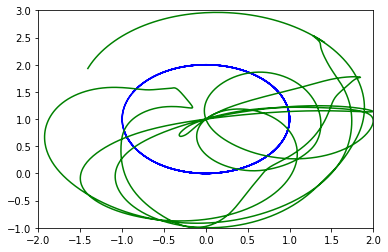

In [ ]:
if __name__ == '__main__':
    
    #ii = 0
    X = torch.linspace(-2,2,10)
    
    func = ODEFunc()
    optimizer = optim.RMSprop(func.parameters())          #this is an optimizer designed to update parameters
    end = time.time()                                     #usually people use SGD but this is a mini-batch approach
                                                          #http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
    #RunningAvgMeter Objects
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)
    
    #TRAINING
    for itr in range(1, niters+1):
        #initial conditions; requires 2D tensor
        true_y0 = torch.tensor([[random(), random(),  random(), random()]])
        
        with torch.no_grad(): #no_grad disables gradient finding when true_y is defined
            #print(torch.mm(true_y0**3,true_A))
            true_y = odeint(Lambda(),true_y0, t, method='adams') 
            #true_y is the solved ODE defined in Lambda
            #odeint only takes a function from nn.Module >> implications? see solver comparision Jupyter
            #it uses Lambda to provide the function to go solve the IVP given true_y0 with the ODE solver on t
            trueSl = getSlopesTorch(X.numpy(),Lambda())
        
        optimizer.zero_grad() #set gradients to zero/ not computed
        
        #batch_y0, batch_t, batch_y = get_batch()
        #feeds odeint the ODEBlock, a set of y values based on random t values and the first ten values of t
        #pred_y = odeint(func, batch_y0, batch_t)
        #deviates from usual Loss of mean squared difference but sum in both cases is positive
        #print(pred_y.detach(),batch_y)
        #---------------------------------------
        predSl = getSlopesTorch(X.numpy(),func)
        
        #loss = torch.mean(torch.abs(pred_y-batch_y)**2) #ask Ivan about predY-bY, also this returns a number
        #--------------------------------------------------
        loss = torch.mean(torch.abs(predSl-trueSl)**2)
        
        loss.backward() #backpropogation
        optimizer.step() #gradient descent and update parameters
        #Update time and loss meters
        time_meter.update(time.time()-end) #takes in time difference to establish velocity see RMS method details
        loss_meter.update(loss.item()) #the loss itself is a delta / change
        
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            #loss = torch.mean(torch.abs(pred_y-true_y)**2)
            #-------------------------------------------------
            predSl = getSlopesTorch(X.numpy(),func)
            
            loss = torch.mean(torch.abs(predSl-trueSl)**2)
            print('Iteration {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
        
            if itr % test_freq == 0:
                visualize(true_y)
                visualize(pred_y)
                
        #torch.save(func.state_dict(), C:\Users\delis\Desktop\DEPython\modelP)
                
        end = time.time()